In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files
from pandas.io.json import json_normalize

import requests # library to handle requests


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge geocoder --yes
import geocoder

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim


!conda install -c conda-forge folium=0.5.0 --yes
import folium


print("All libraries imported.")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    click-7.1.2                |     pyh9f0ad1d_0          64 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    future-0.18.2              |   py36h9f0ad1d_1         714 KB  conda-forge
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    idna-2.10                  |     pyh9f0ad1d_0          52 KB  conda-forge
    p

##  Input data from sources into dataframes:  

### This notebook focuses on data for the Charlottesville VA region; a second notebook was created which focused on the Boulder CO region.

In [2]:
# read in the charlottesville VA crime data
VA_crime_df = pd.read_csv('charlottesville_va_crime.csv')
VA_crime_df.head()

,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,DateReported,HourReported
0,1,Vandalism,202000016766,1200.0,HOLMES AVE,CPD,2020/06/18 23:37:39+00,2337
1,2,Assault Simple,202000016707,1300.0,W MAIN ST,CPD,2020/06/18 13:49:21+00,1349
2,3,Drug Investigation,202000016682,1900.0,EMMET ST N,CPD,2020/06/18 03:59:59+00,359
3,4,Larceny - From Motor Vehicle,202000016650,100.0,GREENWICH CT,CPD,2020/06/17 23:50:17+00,2350
4,5,Suspicious Activity,202000016644,100.0,EMMET ST N,CPD,2020/06/17 22:49:46+00,2249


In [6]:
VA_crime_df.shape

(28214, 9)

In [7]:
# extapulate the year from the date for simplier grouping

VA_crime_df['year'] = pd.DatetimeIndex(VA_crime_df['DateReported']).year
VA_crime_df.head()

,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,DateReported,HourReported,year
0,1,Vandalism,202000016766,1200.0,HOLMES AVE,CPD,2020/06/18 23:37:39+00,2337,2020
1,2,Assault Simple,202000016707,1300.0,W MAIN ST,CPD,2020/06/18 13:49:21+00,1349,2020
2,3,Drug Investigation,202000016682,1900.0,EMMET ST N,CPD,2020/06/18 03:59:59+00,359,2020
3,4,Larceny - From Motor Vehicle,202000016650,100.0,GREENWICH CT,CPD,2020/06/17 23:50:17+00,2350,2020
4,5,Suspicious Activity,202000016644,100.0,EMMET ST N,CPD,2020/06/17 22:49:46+00,2249,2020


In [8]:
# Visualize aggregate crime numbers by year
VA_crime_df.groupby(['year']).size()

year
2015    3408
2016    6561
2017    6213
2018    5108
2019    5043
2020    1881
dtype: int64

In [9]:
#Create subset df for current year
VA_crime_2020_df = VA_crime_df.loc[VA_crime_df['year'] == 2020]

In [10]:
# Remove outliers where block number is not included in police report
VA_crime_2020_df = VA_crime_2020_df.dropna()

In [11]:
#Confirm shape of df has changed
VA_crime_2020_df.shape

(1779, 9)

In [12]:
#Confirm the data types in the df
VA_crime_2020_df.dtypes

RecordID          int64
Offense          object
IncidentID        int64
BlockNumber     float64
StreetName       object
Agency           object
DateReported     object
HourReported      int64
year              int64
dtype: object

In [13]:
# ensure block number is integer and not float for future usage
VA_crime_2020_df['BlockNumber'] = VA_crime_2020_df['BlockNumber'].apply(np.int64)

In [14]:
# define  function to get coordinates for Charlottesville virgina street addresses - used for data scrubbing
def get_street_latlng(block, street):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{},{}, Charlottesville, Virginia'.format(block,street))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [15]:
#Create function that extracts the raw locator data for coordinates via Nominatim to retrieve the neighbourhood

def get_neighborhood_name(coordinates):
    locator = Nominatim(user_agent="myGeocoder")
    location_data = locator.reverse(coordinates)
    
    if len(location_data) == 0:
        return None
    else:
        return location_data

In [16]:
# Test cell for function with one value first
va_crime_neighborhood_entry = get_street_latlng('1100','ELLIOTT AVE')
neighborhood = get_neighborhood_name(va_crime_neighborhood_entry)
print(va_crime_neighborhood_entry)
neighborhood.raw   # extract either hamlet or town based on raw address dictionary returned

[38.01815400273452, -78.4750189625076]


{'place_id': 175388796,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 385361693,
 'lat': '38.018155750000005',
 'lon': '-78.47503059020399',
 'display_name': '1100, Elliott Avenue, Belmont, Charlottesville, Virginia, 22902, United States of America',
 'address': {'house_number': '1100',
  'road': 'Elliott Avenue',
  'hamlet': 'Belmont',
  'town': 'Charlottesville',
  'state': 'Virginia',
  'postcode': '22902',
  'country': 'United States of America',
  'country_code': 'us'},
 'boundingbox': ['38.0180914', '38.0182188', '-78.4750958', '-78.4749625']}

In [ ]:
#Save revised df to csv for further analysis later in notebook
VA_crime_temp_df.to_csv('VA_crimes_new.csv')

In [17]:
#Let's now summarize for the current year and order desc
VA_crimetype_data = VA_crime_2020_df.groupby(['Offense']).size().to_frame(name='Count').reset_index()

VA_crimetype_data_final = VA_crimetype_data.sort_values(by='Count', ascending=False).head(10)

VA_crimetype_data_final

,Offense,Count
76,Suspicious Activity,149
81,Vandalism,143
8,Assault Simple,133
40,Hit and Run,129
13,Assist Citizen - Mental/TDO/ECO,127
45,Larceny - From Motor Vehicle,105
44,Larceny - All Other,92
53,Lost/FoundProperty,89
21,Disorderly Conduct,61
49,Larceny - Shoplifitng,55


In [18]:
#General statistics of the df
VA_crimetype_data_final.describe()

,Count
count,10.000000
mean,108.300000
std,33.293476
min,55.000000
25%,89.750000
50%,116.000000
75%,132.000000
max,149.000000


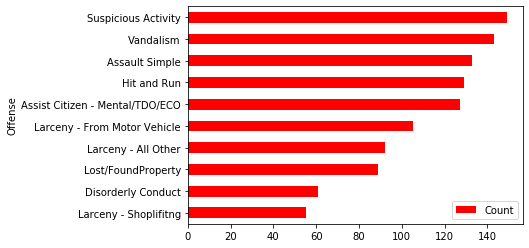

In [19]:
# visualize now the top 10 crimes throughout Charlottesville

VA_crimetype_data_present = VA_crimetype_data_final.sort_values('Count')

VA_crimetype_data_present.plot(x='Offense', y='Count', kind='barh', color = 'red')

In [20]:
# Aside from burglary, our concern about establishment is theft from vehicle for our potential customers.

VA_vehicle_crime_df = VA_crime_2020_df.loc[VA_crime_2020_df['Offense'] == 'Larceny - From Motor Vehicle']
VA_vehicle_crime_df.head()

,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,DateReported,HourReported,year
3,4,Larceny - From Motor Vehicle,202000016650,100,GREENWICH CT,CPD,2020/06/17 23:50:17+00,2350,2020
18,19,Larceny - From Motor Vehicle,202000016512,300,CARLTON RD,CPD,2020/06/16 13:07:46+00,1307,2020
43,44,Larceny - From Motor Vehicle,202080000057,100,LANKFORD AVE,CPD,2020/06/13 18:37:47+00,1837,2020
91,92,Larceny - From Motor Vehicle,202000015760,1000,LONG ST,CPD,2020/06/09 04:40:27+00,440,2020
112,113,Larceny - From Motor Vehicle,202000015473,1600,EMMET ST N,CPD,2020/06/06 16:28:44+00,1628,2020


In [21]:
# read in another scraped, scrubbed charlottesville VA crime data - limited to larceny from motor vehicles for current year by location
VA_vehicle_crime_df = pd.read_csv('VA_vehicle_crimes_new.csv')
VA_vehicle_crime_df.head()

,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,DateReported,HourReported,year,Latitude,Longitude,Neighborhood
0,4,Larceny - From Motor Vehicle,2.020000e+11,100,GREENWICH CT,CPD,2020/06/17 23:50:17+00,2350,2020,38.018987,-78.470492,Belmont
1,19,Larceny - From Motor Vehicle,2.020000e+11,300,CARLTON RD,CPD,2020/06/16 13:07:46+00,1307,2020,38.022550,-78.469842,Belmont
2,44,Larceny - From Motor Vehicle,2.020800e+11,100,LANKFORD AVE,CPD,2020/06/13 18:37:47+00,1837,2020,38.021283,-78.487069,West View Terrace
3,92,Larceny - From Motor Vehicle,2.020000e+11,1000,LONG ST,CPD,2020/06/09 04:40:27+00,440,2020,38.037744,-78.465495,Locust Grove
4,113,Larceny - From Motor Vehicle,2.020000e+11,1600,EMMET ST N,CPD,2020/06/06 16:28:44+00,1628,2020,38.058295,-78.494388,Northerly


In [24]:
# Now by limited crime, let's sort and depict which neighborhoods encounter these offenses

VA_vehicle_crimetype_data = VA_vehicle_crime_df.groupby(['Neighborhood']).size().to_frame(name='Count').reset_index()

VA_vehicle_crimetype_data_final = VA_vehicle_crimetype_data.sort_values(by='Count', ascending=False).head(10)

VA_vehicle_crimetype_data_final

,Neighborhood,Count
6,Starr Hill,22
0,Belmont,21
1,Charlottesville,20
9,West View Terrace,13
5,Northerly,10
7,The Meadows,5
8,Vinegar Hill,5
3,Greenfields,4
4,Locust Grove,3
2,Greenbriar Heights,1


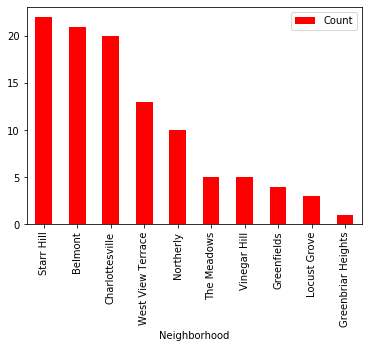

In [27]:
# examine the top 10 neighborhoods throughout Charlottesville with this offense through a simple bar graph

#VA_crimetype_data_present = VA_crimetype_data_final.sort_values('Count')

VA_vehicle_crimetype_data_final.plot(x='Neighborhood', y='Count', kind='bar', color = 'red')

In [37]:
# Now let's sort the table in descending order to restrict to the 5 neighborhoods with the highest crime rates
VA_vehicle_crimetype_data_final.sort_values(['Count'], ascending=False, axis=0, inplace=True)
df_top5 = VA_vehicle_crimetype_data_final.head(5)
df_top5

,Neighborhood,Count
6,Starr Hill,22
0,Belmont,21
1,Charlottesville,20
9,West View Terrace,13
5,Northerly,10


Text(0.5, 1.0, 'Charlottesville Neighborhoods with the Highest Crime Rates')

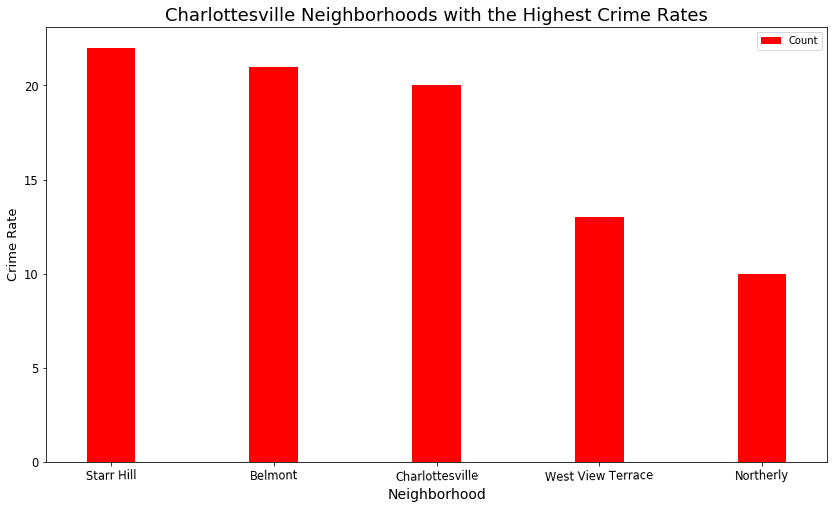

In [41]:
# visualise the results 
chart_top5 = df_top5[['Neighborhood','Count']]
chart_top5.set_index('Neighborhood', inplace=True)

ax = chart_top5.plot(kind='bar',
                     figsize=(14,8),
                     width=0.3,
                     color='red',
                     fontsize=11.5,
                     rot=1)

ax.set_ylabel('Crime Rate', fontsize=13)
ax.set_xlabel('Neighborhood', fontsize=14)
ax.set_title('Charlottesville Neighborhoods with the Highest Crime Rates', fontsize=18)


In [42]:
# Crime map for Charlottesville:  thefts from motor vehicles
world_geo = r'world_countries.json' # geojson file

charlottesville_crime_map = folium.Map(location=[38.029306, -78.4766781], width=1000, height=750,zoom_start=13)

charlottesville_crime_map

In [44]:
# Now let's plot those specific offenses against maps

for lat, lng, point in zip(VA_vehicle_crime_df['Latitude'], VA_vehicle_crime_df['Longitude'],VA_vehicle_crime_df['Neighborhood']):
    label = '{}'.format(point)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radium=1,
                        popup=label,
                        color='red',
                        fill=False,
                        #fill_color='red',
                        #fill_opacity=0.4,
                        parse_html=False).add_to(charlottesville_crime_map)
charlottesville_crime_map

## Now lets evaluate neighborhood content

In [26]:
# Let's get the neighborhood data for Charlottesville VA 
VA_neighborhoods_df = pd.read_csv('Charlottesville_Basemap.csv')
VA_neighborhoods_df

,OBJECTID,NAME,PLANNER,HOUSINGCODE,ENGINEER,created_user,created_date,last_edited_user,last_edited_date,SHAPEarea,SHAPElen,Lat,Long
0,1,North Downtown,BRIAN HALUSKA,MATT FICHTER,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,1.867961e+07,20813.977227,38.03584,-78.47786
1,2,Martha Jefferson,CARRIE RAINEY,PATRICIA CARRINGTON,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,1.162839e+07,16153.741349,38.03201,-78.46751
2,3,Woolen Mills,CARRIE RAINEY,PATRICIA CARRINGTON,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,1.207842e+07,18043.454420,38.02641,-78.46269
3,5,Locust Grove,JOEY WINTER,PATRICIA CARRINGTON,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,BROWNR,2019/01/28 20:00:51+00,3.229089e+07,32502.224681,38.03903,-78.45862
4,6,Greenbrier,JOEY WINTER,MATT FICHTER,CHRIS SIBOLD,NaN,1970/01/01 00:00:00+00,BROWNR,2019/01/28 20:00:51+00,3.369133e+07,29633.406480,38.06043,-78.47461
5,9,The Meadows,JOEY WINTER,MATT FICHTER,CHRIS SIBOLD,NaN,1970/01/01 00:00:00+00,BROWNR,2019/01/28 20:00:51+00,1.637549e+07,22161.975219,38.06009,-78.49655
6,10,Belmont,SHARED,MATT FICHTER,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,2.413348e+07,23065.735086,38.02278,-78.47350
7,11,Fifeville,MATT ALFELE,MATT MCCRACKEN,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,BROWNR,2019/11/14 16:47:51+00,1.432315e+07,16337.489579,38.02595,-78.49444
8,12,Johnson Village,MATT ALFELE,PATRICIA CARRINGTON,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,6.966037e+06,10951.738536,38.02050,-78.50385
9,13,Ridge Street,CARRIE RAINEY,MATT FICHTER,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,1.356927e+07,21091.320281,38.02174,-78.48770


In [27]:
#Confirm the df shape
VA_neighborhoods_df.shape

(19, 13)

In [28]:
# define a function to get coordinates for neighborhoods
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Charlottesville, Virginia'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [29]:
# call the function to get the coordinates, store in a new list using list comprehension
neighborhood_coords = [ get_latlng(neighborhood) for neighborhood in VA_neighborhoods_df["NAME"].tolist() ]

neighborhood_coords

[[38.035840000000064, -78.47785999999996],
 [38.03201000000007, -78.46750999999995],
 [38.026410000000055, -78.46268999999995],
 [38.039030000000025, -78.45861999999994],
 [38.06043000000005, -78.47460999999998],
 [38.06009000000006, -78.49654999999996],
 [38.02278000000007, -78.47349999999994],
 [38.02595000000008, -78.49443999999994],
 [38.02050000000003, -78.50384999999994],
 [38.02174000000008, -78.48769999999996],
 [38.031960000000026, -78.48729999999995],
 [38.04986000000008, -78.50538999999998],
 [38.01806000000005, -78.51289999999995],
 [38.02933000000007, -78.50693999999999],
 [38.03934000000004, -78.51197999999994],
 [38.04341000000005, -78.49839999999995],
 [38.035330000000044, -78.49102999999997],
 [38.03935000000007, -78.48612999999995],
 [38.04898000000003, -78.48622999999998]]

In [30]:
# get the coordinates of Charlottesville Virginia
address = 'Charlottesville, Virginia'

geolocator = Nominatim(user_agent="myGeocoder")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Charlottesville, Virginia {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Charlottesville, Virginia 38.029306, -78.4766781.


In [31]:
# create map of Charlottesville VA using latitude and longitude values
map_VA = folium.Map(location=[latitude, longitude], zoom_start=12)
    
map_VA

In [33]:
# create map of charlottesville and all associated neighborhoods using latitude and longitude values
map_VA = folium.Map(location=[latitude, longitude], zoom_start=12)

# add Neighborhood markers to the map
for lat, long, name in zip(VA_neighborhoods_df['Lat'], VA_neighborhoods_df['Long'], VA_neighborhoods_df['NAME']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',##3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_VA)  
    
map_VA

In [29]:
# Let's Check the data frame as we continue to work 
VA_neighborhoods_df

,OBJECTID,NAME,PLANNER,HOUSINGCODE,ENGINEER,created_user,created_date,last_edited_user,last_edited_date,SHAPEarea,SHAPElen,Lat,Long
0,1,North Downtown,BRIAN HALUSKA,MATT FICHTER,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,1.867961e+07,20813.977227,38.03584,-78.47786
1,2,Martha Jefferson,CARRIE RAINEY,PATRICIA CARRINGTON,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,1.162839e+07,16153.741349,38.03201,-78.46751
2,3,Woolen Mills,CARRIE RAINEY,PATRICIA CARRINGTON,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,1.207842e+07,18043.454420,38.02641,-78.46269
3,5,Locust Grove,JOEY WINTER,PATRICIA CARRINGTON,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,BROWNR,2019/01/28 20:00:51+00,3.229089e+07,32502.224681,38.03903,-78.45862
4,6,Greenbrier,JOEY WINTER,MATT FICHTER,CHRIS SIBOLD,NaN,1970/01/01 00:00:00+00,BROWNR,2019/01/28 20:00:51+00,3.369133e+07,29633.406480,38.06043,-78.47461
5,9,The Meadows,JOEY WINTER,MATT FICHTER,CHRIS SIBOLD,NaN,1970/01/01 00:00:00+00,BROWNR,2019/01/28 20:00:51+00,1.637549e+07,22161.975219,38.06009,-78.49655
6,10,Belmont,SHARED,MATT FICHTER,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,2.413348e+07,23065.735086,38.02278,-78.47350
7,11,Fifeville,MATT ALFELE,MATT MCCRACKEN,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,BROWNR,2019/11/14 16:47:51+00,1.432315e+07,16337.489579,38.02595,-78.49444
8,12,Johnson Village,MATT ALFELE,PATRICIA CARRINGTON,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,6.966037e+06,10951.738536,38.02050,-78.50385
9,13,Ridge Street,CARRIE RAINEY,MATT FICHTER,HUGH BLAKE,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,1.356927e+07,21091.320281,38.02174,-78.48770


In [30]:
#Create subset of the neighborhood df and drop unneeded attributes

VA_neighborhoods_df.drop(['OBJECTID','PLANNER','HOUSINGCODE','ENGINEER','created_user','created_date','last_edited_user','last_edited_date','SHAPEarea','SHAPElen'], axis=1,inplace=True)
VA_neighborhoods_df

,NAME,Lat,Long
0,North Downtown,38.03584,-78.47786
1,Martha Jefferson,38.03201,-78.46751
2,Woolen Mills,38.02641,-78.46269
3,Locust Grove,38.03903,-78.45862
4,Greenbrier,38.06043,-78.47461
5,The Meadows,38.06009,-78.49655
6,Belmont,38.02278,-78.47350
7,Fifeville,38.02595,-78.49444
8,Johnson Village,38.02050,-78.50385
9,Ridge Street,38.02174,-78.48770


In [31]:
#Rename attributes
VA_neighborhoods_df.columns = ['Neighborhood', 'Latitude','Longitude']

In [32]:
# Align with our expectations going forward for further analysis and merging?
VA_neighborhoods_df

,Neighborhood,Latitude,Longitude
0,North Downtown,38.03584,-78.47786
1,Martha Jefferson,38.03201,-78.46751
2,Woolen Mills,38.02641,-78.46269
3,Locust Grove,38.03903,-78.45862
4,Greenbrier,38.06043,-78.47461
5,The Meadows,38.06009,-78.49655
6,Belmont,38.02278,-78.47350
7,Fifeville,38.02595,-78.49444
8,Johnson Village,38.02050,-78.50385
9,Ridge Street,38.02174,-78.48770


## Foursquare API interaction to obtain venue content

In [33]:
#Establishing the foursquare client credentials
CLIENT_ID = 'RHIV0YNGTM1W22DNKASXWVHCXOQ5EIL4I3CPV3S4MCBRWUXL' # your Foursquare ID
CLIENT_SECRET = 'ZSBQTNNYS4PAJY01LPQZ2SR0VXY24XCQ5WNUT0NSLPQGPOT2' # your Foursquare Secret
VERSION = '20200701' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: RHIV0YNGTM1W22DNKASXWVHCXOQ5EIL4I3CPV3S4MCBRWUXL
CLIENT_SECRET:ZSBQTNNYS4PAJY01LPQZ2SR0VXY24XCQ5WNUT0NSLPQGPOT2


In [34]:
# Gathering the lat / long coordinates for single entity trial
neighborhood_latitude = VA_neighborhoods_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = VA_neighborhoods_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = VA_neighborhoods_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values for {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values for North Downtown are 38.035840000000064, -78.47785999999995.


In [35]:
#Given a static radius and limit, formulate the URL to be transmitted to foursquare API call

radius = 500 # define radius

LIMIT = 100 # limit of number of venues returned by Foursquare API


# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display purposes and verification

'https://api.foursquare.com/v2/venues/explore?&client_id=RHIV0YNGTM1W22DNKASXWVHCXOQ5EIL4I3CPV3S4MCBRWUXL&client_secret=ZSBQTNNYS4PAJY01LPQZ2SR0VXY24XCQ5WNUT0NSLPQGPOT2&v=20200608&ll=38.035840000000064,-78.47785999999995&radius=500&limit=100'

In [36]:
#Familiarize ourself with the result json attributes
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5efbc35927946d5a141b4f86'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Charlottesville',
  'headerFullLocation': 'Charlottesville',
  'headerLocationGranularity': 'city',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 38.04034000450007,
    'lng': -78.47215728652805},
   'sw': {'lat': 38.03133999550006, 'lng': -78.48356271347185}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ba6e163f964a520307539e3',
       'name': 'Emancipation Park',
       'location': {'address': 'Main St.',
        'crossStreet': '2nd St.',
        'lat': 38.031947550123775,
        'lng': -78.4802975556727,
        'lab

In [37]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [38]:
# DJM 7/1/2020 - added revised import statement to remove warning message in next cell

from pandas import json_normalize # tranform JSON file into a pandas dataframe

In [39]:
#Let's build the venue listings - trial run first of one entry
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Emancipation Park,Park,38.031948,-78.480298


In [41]:
# Define the function now to build the venue list - used from prior lab trianings

def getNearbyVenues(name, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(name, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
#Trial run with the function above to ensure returns expected values
VA_data_venues = getNearbyVenues(name=nearby_venues['name'],
                                   latitudes=nearby_venues['lat'],
                                   longitudes=nearby_venues['lng']
                                  )


#VA_data_venues = getNearbyVenues(name='Emancipation Park',
#                                   latitudes=38.031948,
#                                   longitudes=-78.480298
#                                  )

Emancipation Park


In [44]:
#VA_neighborhoods_df - now we ensure all neighborhoods are part of the function call going forward


VA_data_venues = getNearbyVenues(name=VA_neighborhoods_df['Neighborhood'],
                                   latitudes=VA_neighborhoods_df['Latitude'],
                                   longitudes=VA_neighborhoods_df['Longitude']
                                  )

North Downtown
Martha Jefferson
Woolen Mills
Locust Grove
Greenbrier
The Meadows
Belmont
Fifeville
Johnson Village
Ridge Street
Starr Hill
Barracks Road
Fry's Spring
Jefferson Park Avenue
Lewis Mountain
Venable
10th & Page
Rose Hill
Barracks / Rugby


In [45]:
# Lets confirm the shape and top entries in the new df
print(VA_data_venues.shape)
VA_data_venues.head()

(243, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
0,North Downtown,38.03584,-78.47786,Emancipation Park,4ba6e163f964a520307539e3,38.031948,-78.480298,Park
1,Martha Jefferson,38.03201,-78.46751,La Michoacana,4b5b3ed6f964a52002ee28e3,38.031888,-78.466862,Mexican Restaurant
2,Martha Jefferson,38.03201,-78.46751,Riverside Lunch,4b943f04f964a520f57034e3,38.033248,-78.462649,Burger Joint
3,Martha Jefferson,38.03201,-78.46751,Tubby's Restaurant,4b72fef0f964a5209d942de3,38.031879,-78.464197,Sandwich Place
4,Martha Jefferson,38.03201,-78.46751,Jak'n Jill,4d38cc869ae66dcb1ece19e7,38.032517,-78.463014,Hot Dog Joint


In [46]:
# taken from prior lab work to ensure varying venues are in the df

print('There were {} unique venue categories returned.'.format(len(VA_data_venues['Venue Category'].unique())))

There were 109 unique venue categories returned.


In [47]:
# Similar activity to ensure unique venues are present in the df

print('There are {} unique venues.'.format(len(VA_data_venues['Venue id'].unique())))

There are 207 unique venues.


In [48]:
# Lets now group all venues by neighborhood
va_grouped_venues = VA_data_venues.groupby('Neighborhood').nunique('Venue Category')
va_grouped_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,,
10th & Page,1,1,1,40,40,38,38,34
Barracks / Rugby,1,1,1,2,2,2,2,2
Barracks Road,1,1,1,36,36,36,36,31
Belmont,1,1,1,19,19,18,18,16
Fifeville,1,1,1,4,4,4,4,4
Fry's Spring,1,1,1,3,3,3,3,3
Greenbrier,1,1,1,1,1,1,1,1
Jefferson Park Avenue,1,1,1,3,3,3,3,3
Johnson Village,1,1,1,1,1,1,1,1


In [49]:
VA_data_venues.groupby('Venue Category').nunique()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
Venue Category,,,,,,,,
African Restaurant,1,1,1,1,1,1,1,1
American Restaurant,1,1,1,2,2,2,2,1
Art Gallery,2,2,2,2,2,2,2,1
Arts & Crafts Store,1,1,1,1,1,1,1,1
Asian Restaurant,1,1,1,1,1,1,1,1
Athletics & Sports,1,1,1,1,1,1,1,1
Auto Garage,1,1,1,1,1,1,1,1
BBQ Joint,5,5,5,6,6,6,6,1
Bagel Shop,4,4,4,2,3,3,3,1


## Analyze each neighbornood in greater detail - what are their offerings and top venues

In [50]:
# one hot encoding
charlottesville_onehot = pd.get_dummies(VA_data_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
charlottesville_onehot['Neighborhood'] = VA_data_venues['Neighborhood'] 

# move neighbourhood column to the first column
fixed_columns = [charlottesville_onehot.columns[-1]] + list(charlottesville_onehot.columns[:-1])
charlottesville_onehot = charlottesville_onehot[fixed_columns]

charlottesville_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Business Service,Café,Cajun / Creole Restaurant,Candy Store,Chinese Restaurant,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Farmers Market,Flea Market,Food,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gas Station,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lighting Store,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Mountain,Movie Theater,New American Restaurant,Office,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Soup Place,Southern / Soul Food Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Tapas Restaurant,Taxi,Thai Restaurant,Thrift / Vintage Store,Trail,Train Station,Tree,Video Store,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,North Downtown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Martha Jefferson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Martha Jefferson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Martha Jefferson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Martha Jefferson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
#Confirming the shape of the onehot df
charlottesville_onehot.shape

(243, 110)

In [52]:
#Grouping again by neighborhood the venue types
charlottesville_grouped  = charlottesville_onehot.groupby('Neighborhood').mean().reset_index()
charlottesville_grouped

,Neighborhood,African Restaurant,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Business Service,Café,Cajun / Creole Restaurant,Candy Store,Chinese Restaurant,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Farmers Market,Flea Market,Food,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gas Station,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lighting Store,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Mountain,Movie Theater,New American Restaurant,Office,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Soup Place,Southern / Soul Food Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Tapas Restaurant,Taxi,Thai Restaurant,Thrift / Vintage Store,Trail,Train Station,Tree,Video Store,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10th & Page,0.000000,0.000000,0.000000,0.000000,0.025,0.00,0.000000,0.025000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.025000,0.025000,0.000000,0.000000,0.000000,0.000000,0.075000,0.025,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.025,0.000000,0.025000,0.00,0.025,0.000000,0.000000,0.025000,0.000000,0.000000,0.00,0.000000,0.025000,0.025000,0.000000,0.025000,0.025000,0.0,0.025000,0.00,0.025000,0.000000,0.0,0.025000,0.000000,0.000000,0.00,0.050000,0.000000,0.025000,0.000000,0.025000,0.00,0.000000,0.000000,0.025000,0.025000,0.025000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.050000,0.00,0.000000,0.025000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05,0.000000,0.000000,0.025,0.000000,0.000000,0.000000,0.00,0.000000,0.025000,0.000000,0.025000,0.0,0.00,0.00,0.025000,0.000000,0.000000
1,Barracks / Rugby,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.000000
2,Barracks Road,0.000000,0.000000,0.000000,0.027778,0.000,0.00,0.000000,0.000000,0.000000,0.027778,0.000000,0.027778,0.027778,0.000000,0.000000,0.000000,0.000000,0.027778,0.027778,0.027778,0.000000,0.000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.055556,0.000000,0.000000,0.000000,0.027778,0.000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.027778,0.000000,0.000000,0.027778,0.000000,0.000000,0.0,0.027778,0.00,0.000000,0.000000,0.0,0.027778,0.000000,0.027778,0.00,0.000000,0.000000,0.000000,0.027778,0.000000,0.00,0.000000,0.000000,0.055556,0.027778,0.000000,0.027778,0.0,0.000000,0.000000,0.00,0.027778,0.00,0.0,0.027778

In [54]:
# let's review the top 5 venues types by neighborhood
# loop used from prior lab exercises

num_top_venues = 5

for hood in charlottesville_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = charlottesville_grouped[charlottesville_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----10th & Page----
                             venue  freq
0                          Brewery  0.08
1                      Pizza Place  0.05
2  Southern / Soul Food Restaurant  0.05
3               Italian Restaurant  0.05
4                      Coffee Shop  0.05


----Barracks / Rugby----
                venue  freq
0  Chinese Restaurant   0.5
1          Playground   0.5
2               Hotel   0.0
3  Mexican Restaurant   0.0
4         Pizza Place   0.0


----Barracks Road----
                      venue  freq
0             Women's Store  0.08
1               Coffee Shop  0.06
2  Mediterranean Restaurant  0.06
3              Burger Joint  0.06
4               Yoga Studio  0.03


----Belmont----
             venue  freq
0      Yoga Studio  0.11
1        BBQ Joint  0.11
2              Bar  0.11
3  Bed & Breakfast  0.05
4      Pizza Place  0.05


----Fifeville----
                venue  freq
0            Gym Pool  0.25
1               Hotel  0.25
2      Ice Cream Shop  0.25
3          

In [55]:
#Function to return the most common venue sorted in decending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [56]:
# Now we look for the top 10 venues by neighborhood and append into df
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
location_venues_sorted = pd.DataFrame(columns=columns)
location_venues_sorted['Neighborhood'] = charlottesville_grouped['Neighborhood']

for ind in np.arange(charlottesville_grouped.shape[0]):
    location_venues_sorted.iloc[ind, 1:] = return_most_common_venues(charlottesville_grouped.iloc[ind, :], num_top_venues)

location_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10th & Page,Brewery,Coffee Shop,Italian Restaurant,Pizza Place,Southern / Soul Food Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Juice Bar,Mexican Restaurant,Beer Bar
1,Barracks / Rugby,Playground,Chinese Restaurant,Gym,Donut Shop,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop
2,Barracks Road,Women's Store,Burger Joint,Mediterranean Restaurant,Coffee Shop,Bookstore,Boutique,Breakfast Spot,Pizza Place,Park,Mobile Phone Shop
3,Belmont,Yoga Studio,BBQ Joint,Bar,Tapas Restaurant,Chinese Restaurant,Cajun / Creole Restaurant,Pizza Place,Mexican Restaurant,Restaurant,Bed & Breakfast
4,Fifeville,Gym Pool,Hotel,Ice Cream Shop,Playground,Gift Shop,Gourmet Shop,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant
5,Fry's Spring,Pool,IT Services,Food,Yoga Studio,Donut Shop,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store
6,Greenbrier,Mountain,Yoga Studio,Dumpling Restaurant,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega
7,Jefferson Park Avenue,Coffee Shop,Hotel,Bagel Shop,Yoga Studio,Farmers Market,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio
8,Johnson Village,Pharmacy,Dumpling Restaurant,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega
9,Lewis Mountain,Wings Joint,College Gym,Gourmet Shop,Convenience Store,BBQ Joint,Bank,Yoga Studio,Dumpling Restaurant,Coffee Shop,Comfort Food Restaurant


## Introduce the K-Means partitioned base clustering algorithm

In [57]:
# Here we now introduce the k - means clustering algorithm

#set number of clusters - typically use 5 in most exercises
kclusters = 5

charlottesville_grouped_clustering = charlottesville_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(charlottesville_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 3, 2, 1, 4, 1], dtype=int32)

In [58]:
# Associate report labels to the array indicators

# add clustering labels
location_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

charlottesville_merged = VA_neighborhoods_df


# merge grouped data set with location df to add latitude/longitude for each location
charlottesville_merged = charlottesville_merged.join(location_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

charlottesville_merged.head()


,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North Downtown,38.03584,-78.47786,0,Park,Yoga Studio,Dumpling Restaurant,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega
1,Martha Jefferson,38.03201,-78.46751,1,Pizza Place,Furniture / Home Store,Park,Mexican Restaurant,Bank,Sandwich Place,Burger Joint,Hot Dog Joint,Pool,Clothing Store
2,Woolen Mills,38.02641,-78.46269,1,Park,Art Gallery,Pool,Business Service,Trail,Comfort Food Restaurant,Deli / Bodega,Donut Shop,Clothing Store,Coffee Shop
3,Locust Grove,38.03903,-78.45862,1,Pizza Place,Tree,Pharmacy,Ice Cream Shop,Gym,Gas Station,Garden Center,Candy Store,Chinese Restaurant,Clothing Store
4,Greenbrier,38.06043,-78.47461,2,Mountain,Yoga Studio,Dumpling Restaurant,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega


In [59]:
# Remove any NAN cluster labels outlyiers

charlottesville_merged = charlottesville_merged[charlottesville_merged.Cluster_Labels.notnull()]


In [60]:
# Need to change cluster labels from float to int to make next cell work - had some challenges from earlier cells not properly being formatted

charlottesville_merged['Cluster_Labels'] = charlottesville_merged['Cluster_Labels'].apply(np.int64)



In [62]:
#Lets confirm the df before next steps
charlottesville_merged.head()

,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North Downtown,38.03584,-78.47786,0,Park,Yoga Studio,Dumpling Restaurant,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega
1,Martha Jefferson,38.03201,-78.46751,1,Pizza Place,Furniture / Home Store,Park,Mexican Restaurant,Bank,Sandwich Place,Burger Joint,Hot Dog Joint,Pool,Clothing Store
2,Woolen Mills,38.02641,-78.46269,1,Park,Art Gallery,Pool,Business Service,Trail,Comfort Food Restaurant,Deli / Bodega,Donut Shop,Clothing Store,Coffee Shop
3,Locust Grove,38.03903,-78.45862,1,Pizza Place,Tree,Pharmacy,Ice Cream Shop,Gym,Gas Station,Garden Center,Candy Store,Chinese Restaurant,Clothing Store
4,Greenbrier,38.06043,-78.47461,2,Mountain,Yoga Studio,Dumpling Restaurant,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega


In [64]:
# create a map now with the clustered neighborhood indicators layers atop  -- new from 3-3-2 neighborhoods exercise 6/26/2020

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(charlottesville_merged['Latitude'], charlottesville_merged['Longitude'], charlottesville_merged['Neighborhood'], charlottesville_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [65]:
#Examining the first of 5 cluster content
charlottesville_merged.loc[charlottesville_merged['Cluster_Labels'] == 0, charlottesville_merged.columns[[0] + list(range(4, charlottesville_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North Downtown,Park,Yoga Studio,Dumpling Restaurant,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega


In [66]:
#Examining the second of 5 cluster content
charlottesville_merged.loc[charlottesville_merged['Cluster_Labels'] == 1, charlottesville_merged.columns[[0] + list(range(4, charlottesville_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Martha Jefferson,Pizza Place,Furniture / Home Store,Park,Mexican Restaurant,Bank,Sandwich Place,Burger Joint,Hot Dog Joint,Pool,Clothing Store
2,Woolen Mills,Park,Art Gallery,Pool,Business Service,Trail,Comfort Food Restaurant,Deli / Bodega,Donut Shop,Clothing Store,Coffee Shop
3,Locust Grove,Pizza Place,Tree,Pharmacy,Ice Cream Shop,Gym,Gas Station,Garden Center,Candy Store,Chinese Restaurant,Clothing Store
5,The Meadows,Hotel,Fried Chicken Joint,Chinese Restaurant,Lighting Store,Diner,Ice Cream Shop,Steakhouse,Supermarket,Bagel Shop,Indian Restaurant
6,Belmont,Yoga Studio,BBQ Joint,Bar,Tapas Restaurant,Chinese Restaurant,Cajun / Creole Restaurant,Pizza Place,Mexican Restaurant,Restaurant,Bed & Breakfast
7,Fifeville,Gym Pool,Hotel,Ice Cream Shop,Playground,Gift Shop,Gourmet Shop,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant
9,Ridge Street,Park,Athletics & Sports,Taxi,Shopping Mall,Donut Shop,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store
10,Starr Hill,Italian Restaurant,Coffee Shop,Southern / Soul Food Restaurant,Seafood Restaurant,Mexican Restaurant,Hotel,Speakeasy,Brewery,American Restaurant,Mediterranean Restaurant
11,Barracks Road,Women's Store,Burger Joint,Mediterranean Restaurant,Coffee Shop,Bookstore,Boutique,Breakfast Spot,Pizza Place,Park,Mobile Phone Shop
13,Jefferson Park Avenue,Coffee Shop,Hotel,Bagel Shop,Yoga Studio,Farmers Market,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio


In [67]:
#Examining the third of 5 cluster content
charlottesville_merged.loc[charlottesville_merged['Cluster_Labels'] == 2, charlottesville_merged.columns[[0] + list(range(4, charlottesville_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Greenbrier,Mountain,Yoga Studio,Dumpling Restaurant,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega


In [68]:
#Examining the fourth of 5 cluster content
charlottesville_merged.loc[charlottesville_merged['Cluster_Labels'] == 3, charlottesville_merged.columns[[0] + list(range(4, charlottesville_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Fry's Spring,Pool,IT Services,Food,Yoga Studio,Donut Shop,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store
15,Venable,Pool,Office,Yoga Studio,Candy Store,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop


In [69]:
#Examining the last cluster content
charlottesville_merged.loc[charlottesville_merged['Cluster_Labels'] == 4, charlottesville_merged.columns[[0] + list(range(4, charlottesville_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Johnson Village,Pharmacy,Dumpling Restaurant,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega


In [91]:
# One last review of the dataset
charlottesville_merged

,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North Downtown,38.03584,-78.47786,0,Park,Yoga Studio,Dumpling Restaurant,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega
1,Martha Jefferson,38.03201,-78.46751,1,Pizza Place,Furniture / Home Store,Park,Mexican Restaurant,Bank,Sandwich Place,Burger Joint,Hot Dog Joint,Pool,Clothing Store
2,Woolen Mills,38.02641,-78.46269,1,Park,Art Gallery,Pool,Business Service,Trail,Comfort Food Restaurant,Deli / Bodega,Donut Shop,Clothing Store,Coffee Shop
3,Locust Grove,38.03903,-78.45862,1,Pizza Place,Tree,Pharmacy,Ice Cream Shop,Gym,Gas Station,Garden Center,Candy Store,Chinese Restaurant,Clothing Store
4,Greenbrier,38.06043,-78.47461,2,Mountain,Yoga Studio,Dumpling Restaurant,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega
5,The Meadows,38.06009,-78.49655,1,Hotel,Fried Chicken Joint,Chinese Restaurant,Lighting Store,Diner,Ice Cream Shop,Steakhouse,Supermarket,Bagel Shop,Indian Restaurant
6,Belmont,38.02278,-78.47350,1,Yoga Studio,BBQ Joint,Bar,Tapas Restaurant,Chinese Restaurant,Cajun / Creole Restaurant,Pizza Place,Mexican Restaurant,Restaurant,Bed & Breakfast
7,Fifeville,38.02595,-78.49444,1,Gym Pool,Hotel,Ice Cream Shop,Playground,Gift Shop,Gourmet Shop,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant
8,Johnson Village,38.02050,-78.50385,4,Pharmacy,Dumpling Restaurant,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega
9,Ridge Street,38.02174,-78.48770,1,Park,Athletics & Sports,Taxi,Shopping Mall,Donut Shop,Clothing Store,Coffee Shop,College Gym,Comfort Food Restaurant,Convenience Store


Please note, a similar, second notebook was created with a similar approach for the Boulder CO region - the capstone project submission page only allows one notebook to be referenced.  We opted to keep these segregated based on city profile and unique data formats, along with ease of navigating.